<a href="https://colab.research.google.com/github/SudeepSarkar/Computer-Vision-Course/blob/main/Lecture_4_Spectral_Clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Examples of data for which K-means or EM does not work

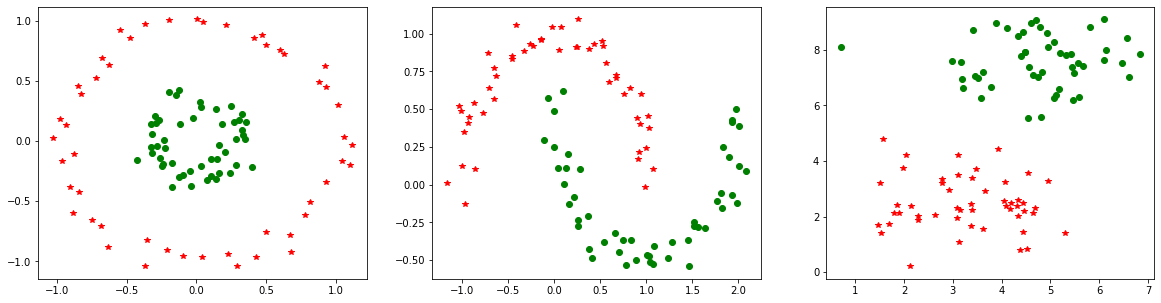

In [2]:
from sklearn.datasets import make_circles, make_moons, make_blobs
import matplotlib.pyplot as plt
import numpy as np
import torch  #pytorch
np.set_printoptions(precision=2)

# -- Circles data
CX, Cy = circles = make_circles (100, noise = 0.07, factor = 0.3)
# CX has the data points in rows and Cy has the corresponding class label.
# We sort the data so that data from each class is contiguous. This is not
# needed, it is just for convinience for later illustrations.
indices = np.argsort(Cy)
CX = CX[indices]
Cy = Cy[indices]

# plot data
colors = ['r*', 'go', 'bx', 'yo', 'ro'] # colors to use for the two classes.
plt.figure(figsize=(20, 5))
plt.subplot(1,3,1)
for i in range (CX.shape[0]) :
  plt.plot(CX[i,0], CX[i,1], colors[Cy[i]])

#  -- Half moon data
MX, My = circles = make_moons (100, noise = 0.07)
indices = np.argsort(My)
MX = MX[indices]
My = My[indices]
plt.subplot(1,3,2)

for i in range (MX.shape[0]) :
  plt.plot(MX[i,0], MX[i,1], colors[My[i]])

#  -- Blobs data
BX, By = circles = make_blobs(n_samples=100, n_features=2, centers=2, cluster_std=1.0, center_box=(-10.0, 10.0), )
indices = np.argsort(By)
BX = BX[indices]
By = By[indices]
plt.subplot(1,3,3)

for i in range (BX.shape[0]) :
  plt.plot(BX[i,0], BX[i,1], colors[By[i]])



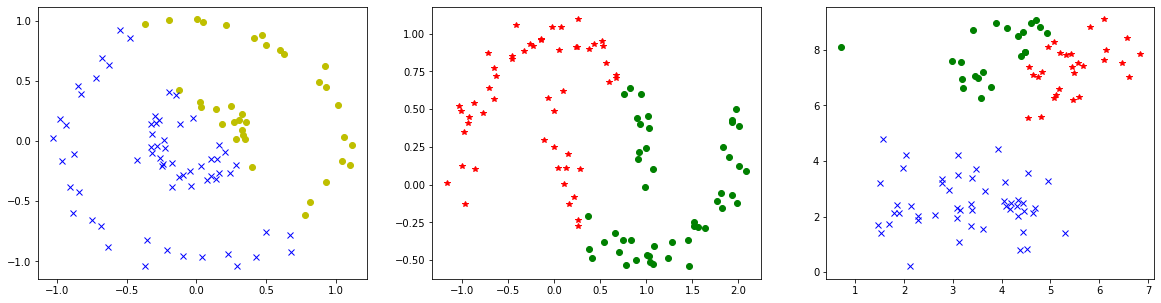

In [3]:
# k-means on this data - on GPUs (using cuda)
def nD_k_Means (data, n_classes) :
    # nD K Means  -- 
    # data is a 2D tensor n_data by n_dim in size. Each row is a data vector.
    # returns the 2D tensor n_data by 1 vector assigning a data point to one of the n_classes
    # along with the mean value of each class.
    n_dim = data.shape[1];
    n_data = data.shape[0];
    # -- initialization -- randomly select points in the range
    data_max, ind = torch.max(data, 0)
    data_min, ind = torch.min(data, 0)
    mu = torch.zeros(n_classes, n_dim).cuda() 
    # randomly pick n_classes points from the data a initial means
    mu = data [torch.randint(n_data, (n_classes,)), :] 
    for i in range (20): 
        # -- Assignment-step-------------------------
        distances = (data[:, None, :] - mu[None, :,  :])**2
        distances = distances.sum(2) #n_data by n_classes array of distances from each of the K means 
        val, ind = torch.min(distances, 1)
        Z = torch.zeros((n_data, n_classes)).cuda ()
        Z[torch.arange(n_data,), ind] = 1       
        #--- Mean computation step
        N = torch.sum(Z, 0)
        mu = (data[:,None,:] * Z[:,:,None]).sum(0)/N[:,None]
    # return results
    val, ind = torch.max(Z, 1)
    return(ind, mu)

# k-means on Circles data
labels, mu = nD_k_Means (torch.tensor(CX.copy()).cuda(), 2)
plt.figure(figsize=(20, 5))
plt.subplot(1,3,1)
for i in range (CX.shape[0]) :
  plt.plot(CX[i,0], CX[i,1], colors[labels[i]+2])

# k-means on Moon data
labels, mu = nD_k_Means (torch.tensor(MX.copy()).cuda(), 2)
plt.subplot(1,3,2)
for i in range (MX.shape[0]) :
  plt.plot(MX[i,0], MX[i,1], colors[labels[i]])

# k-means on Blobs data
labels, mu = nD_k_Means (torch.tensor(BX.copy()).cuda(), 3)
plt.subplot(1,3,3)
for i in range (BX.shape[0]) :
  plt.plot(BX[i,0], BX[i,1], colors[labels[i]])


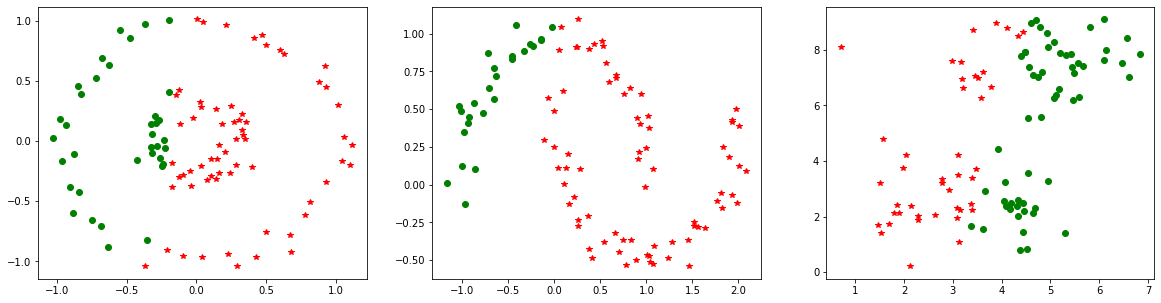

In [4]:
# try EM on this -- using cuda
def nD_EM_GMM (data, n_classes) :
    # nD GMM  -- we will estimate the gaussian paramters of "data"
    # data is a 2D tensor n_data by n_dim in size. Each row is a data vector.
    # returns the 2D tensor n_data by n_dim probability of each data point being each class.

    n_dim = data.shape[1];
    n_data = data.shape[0];
    # -- initialization -- randomly select points in the range
    data_max, ind = torch.max(data, 0)
    data_min, ind = torch.min(data, 0)
    # mu = torch.zeros(n_classes, n_dim).cuda() 
    # randomly pick n_classes number of points from the data as initial mean estimates
    mu = data [torch.randint(n_data, (n_classes,)), :] 
    # n_classes by n_dim tensor -- one mean (rows) for each of the n_classes mixture components (classes).
    data_var = torch.var(data, 0)/10 # can use variance of data to initialize
    Sigma = torch.zeros(n_classes, n_dim, n_dim).double().cuda()  
    for d in range(n_dim) :
        Sigma[: , d, d] = data_var [d] 
    #n_classes by n_dim by n_dim covariance tensor
    pi = torch.ones((n_classes,1)).cuda()/ n_classes # n_classes by 1 tensor -- equal mixture probabilities
    Z = torch.zeros([n_data, n_classes]).cuda()  # creates an zero tensor
    for i in range (20): 
        # -- E-step-------------------------
        for k in range(n_classes) :
          Z[:,k] = pi[k]*torch.distributions.multivariate_normal.MultivariateNormal (mu[k,:], covariance_matrix= Sigma[k, :, :]).log_prob(data).exp ()    
        Z = Z/(Z.sum(1)[:,None])  # normalize the Z rows.
        # -- M-step-------------------------
        N = Z.sum(0)
        mu = (data[:,None,:] * Z[:,:,None]).sum(0)/N[:,None]
        d = data[:, None, :] - mu[None, :,  :] 
        d = torch.matmul (d [:,:,:,None], d [:,:,None,:])  
        Sigma = Z[:,:, None, None] * d  # performing the product with z_{ik} Sigma is a N by n_classes by n_dim by n_dim tensor 
        Sigma = (Sigma.sum(0))/N[:,None,None]
        pi = N/N.sum()
        #print("\n mu=", mu.shape, mu, "\n Sigma =", Sigma.shape, Sigma, "\n pi=", pi, "\n data=", data.shape)
    return(Z, mu, Sigma)

# -- EM on Circles
Z, mu, Sigma = nD_EM_GMM (torch.from_numpy(CX.copy()).cuda(), 2)
val, labels = torch.max(Z, 1)
plt.figure(figsize=(20, 5))
plt.subplot(1,3,1)
for i in range (CX.shape[0]) :
  plt.plot(CX[i,0], CX[i,1], colors[labels[i]])

# --- EM on Moon Shape
Z, mu, Sigma = nD_EM_GMM (torch.from_numpy(MX.copy()).cuda(), 2)
val, labels = torch.max(Z, 1)
plt.subplot(1,3,2)
for i in range (MX.shape[0]) :
  plt.plot(MX[i,0], MX[i,1], colors[labels[i]])

# --- EM on Blobs Shape
Z, mu, Sigma = nD_EM_GMM (torch.from_numpy(BX.copy()).cuda(), 2)
val, labels = torch.max(Z, 1)
plt.subplot(1,3,3)
for i in range (BX.shape[0]) :
  plt.plot(BX[i,0], BX[i,1], colors[labels[i]])

# Transformation of data to graph and then to a matrix

If you observe the datasets, we want to group the first dataset points into concentric circles and half-circles in the other. The core property we are trying to use is **local** distance among points. We want to associate points together if they are locally together. Local distances matter more than distances that are far away. Distances between points that are far away should not factor into the clustering. If we have a grouping strategy where only local distances play the determining role, we would have a solution. Graph spectral grouping is such an approach.

We will capture the local properties in a weighted graph and then use the matrix representation of this graph to transform the points into space when local distances are captured accurately at the expense of far-away distances. In this transformed space, simple k-means or EM or a linear classifier will work.

The first step in the process is to represent the data collection, $D=\{ \mathbf{x_i} | i=1,\cdots,N\}$ as a graph, $G=(V, E)$. Each data element, $\mathbf{x_i}$, is represented by a vertex (or node) in that graph; there is a one-to-one correspondence between the vertices and the data elements. Note that the graph will be as large as the dataset. There are edges (sometimes referred to as links) between the vertices associated with **weights**. The weight, $w_{ij}$ for each edge (or link) between two vertices, $v_i$ and $v_j$, is a non-negative number ($w_{ij} \ge 0$) capturing the **similarity** of the data element. One possibility is a Gaussian similarity function given by:

\begin{equation}
w_{ij} = s({\bf x_i}, {\bf x_j}) = \exp \left ( - ||{\bf x_i} - {\bf x_j}||^2/2 \sigma^2 \right ) 
\end{equation}

It is worth pointing out that one can have other definitions of similarity. Also, note that the concept of *distance* between data elements is *inversely* related to *similarity*. 

If two vertices are not connected, i.e., two data elements are not at all similar, then it means that $w_{ij} = 0$. 

The weight, $w_{ii}$, is typically assigned zero, i.e., no self-loops. However, some have used the diagonal values to capture the relative importance among the data element. For example, the diagonal entries could be confidence values associated with the corresponding data element. More confident data elements will factor prominently in the grouping. An example is in ([Sarkar and Boyer, 1996](https://marathon.csee.usf.edu/~sarkar/PDFs/change-cvpr.pdf); [Sarkar and Boyer, 1998](https://figment.csee.usf.edu/~sarkar/PDFs/change-cviu.pdf)), where the data elements are boundary contours pieces in images, the diagonal values are inversely proportional to the fit of the contour pieces to straight lines or arcs.

The similarity relationship is symmetric, so the edges are also **undirected**, i.e., $w_{ji} = w_{ij}$. 

We can organize these weights as a $N \times N$ matrix $W$, called the **adjacency matrix**. The matrix will be **symmetric**. 




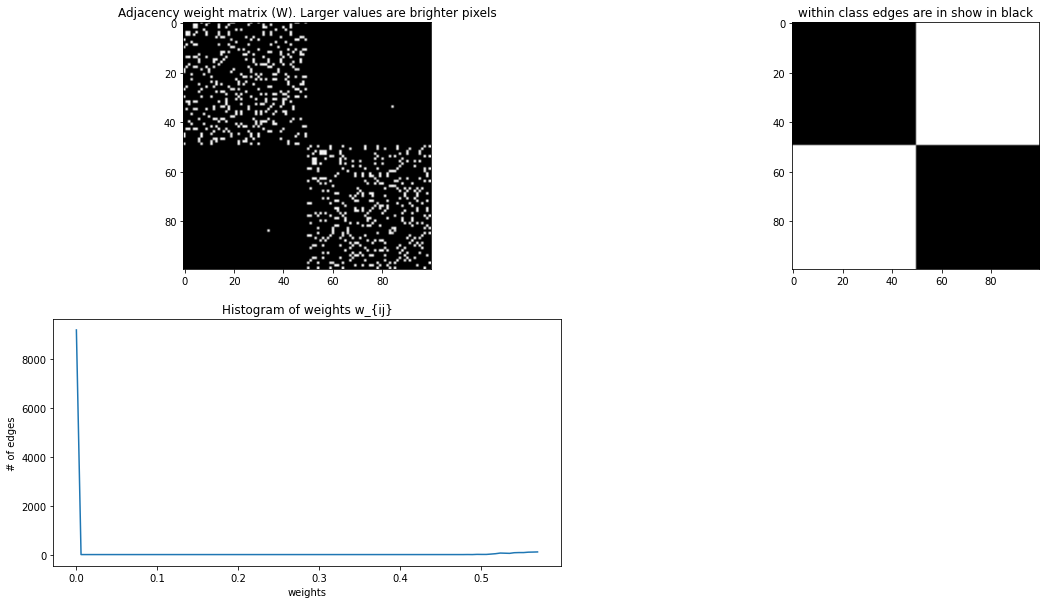

In [5]:
# Example of the graph construction

import torch
import numpy as np
import matplotlib.pyplot as plt

# Vary these parameters and conduct an ablation study of the quality of the separation
batch_size = 100  # batchsize for distance computation. Pairwise distance computation is the most expensive step
kernel_width = 0.7 # bandwidth of the Gaussian similarity
k_neighbors = 10  # number of nearest neighbors considered to compute the graph
data = MX.copy()  # select the dataset to operate on
data_labels = My.copy() # true labels for the data

#----------------------Functions used--------------------
#`squared_distance_batch` contains some broadcast magic that allows us to compute the distance from each point in a batch to all points in the data.
# See - https://numpy.org/doc/stable/user/basics.broadcasting.html
#  and https://scipy-lectures.org/intro/numpy/operations.html
def squared_distance_batch(b, a):
    #print(a.shape, a[None,:].shape, b.shape, b[:,None,:].shape)
    return (((a[None,:,:] - b[:,None,:]) ** 2).sum(2))

def gaussian(squared_dist, bandwidth):
    return torch.exp(-0.5 * (squared_dist / (bandwidth**2))) / (bandwidth * torch.sqrt(2 * torch.tensor(np.pi)))

#---------------------- Main code starts here --------------------
X = torch.from_numpy(data).cuda()
N = X.shape[0]
W = torch.zeros((X.shape[0], X.shape[0]))
for i in range(0, N, batch_size):
    s = slice(i, min(N, i + batch_size))
    distance = squared_distance_batch(X, X[s])
    W[:,s] = distance
#--------------------Section 1: k-Nearest Neighbors distances only----------------
# keep k-nearest neighbors. zero out rest
sorted, indices = torch.sort(W, dim=1, descending=False)
for i in range(N) :
    for j in range (k_neighbors , N) :
        W[i, indices[i, j]] = 9999.0 #large distance
# Need to keep the weight matrix symmetric, otherwise we essentially have a direct graph and spectral clustering will not work
W = 0.5*(W+W.transpose(0,1))

#--------------------Section 2: What is this step doing?----------------
#for i in range(N) :
#    for j in range(N) :
#        for k in range(N) :
#            w = W[i,k] + W[k,j]
#            if (w < W[i,j]) :
#                W[i,j] = w
#-----------------------------------------------------------

W = gaussian(W, kernel_width)

# Zero out the diagonal. In an application, these could be replaced by confidence 
# values associated with data elements or to express relative importance among 
# data elements.
torch.diagonal(W).fill_(0)

#---------------------- Main code ends here --------------------
# Visualize the matrix
plt.figure(figsize=(20,10))
A = W.cpu()
plt.subplot(2,2,1)
plt.imshow(A, 'gray')
plt.title('Adjacency weight matrix (W). Larger values are brighter pixels')

plt.subplot(2,2,2)
plt.imshow(My[:, None] ^ My[:,None].transpose(), 'gray')
plt.title ('within class edges are in show in black')

plt.subplot(2,2,3)
W_hist = torch.histc(W, 100).cpu()
x_hist = torch.linspace(A.min(), A.max(), 100).cpu()
plt.plot(x_hist, W_hist)
plt.xlabel('weights')
plt.ylabel('# of edges')
plt.title('Histogram of weights w_{ij}');



# Inclass Work (15 min)

Breakout into groups of two and experiment with the above code. Report on the following and submit directly on canvas as pdf. 

1. Comment of the nature of the weight matrix for the circles, moon, and blobs data.
2. Change the value of k in computation of the nearest neighbors and comment on the impact on the weight matrix.

In [6]:
# torch code snippet to demonstrate how sorting can be used to select the k-nearest neighbors in a weighted graph. 
# Is it possible to replace the for loops with just statements? Let me know if you find a solution.
# for-loops slows processing down significantly.

x = torch.randn(3, 4)
sorted, index = torch.sort(x, dim=1, descending=True)
print(x, "\n", sorted, "\n", index, "\n")
for i in range(3) :
  for j in range (2,4) :
    print(i, j, index[i,j])
    x[i, index[i,j]] = 0
print(x)


tensor([[-2.1737, -0.7031,  0.3261, -0.6332],
        [ 0.1683, -1.0596, -1.0154,  1.3052],
        [-0.1275, -1.9488, -1.0870,  0.4655]]) 
 tensor([[ 0.3261, -0.6332, -0.7031, -2.1737],
        [ 1.3052,  0.1683, -1.0154, -1.0596],
        [ 0.4655, -0.1275, -1.0870, -1.9488]]) 
 tensor([[2, 3, 1, 0],
        [3, 0, 2, 1],
        [3, 0, 2, 1]]) 

0 2 tensor(1)
0 3 tensor(0)
1 2 tensor(2)
1 3 tensor(1)
2 2 tensor(2)
2 3 tensor(1)
tensor([[ 0.0000,  0.0000,  0.3261, -0.6332],
        [ 0.1683,  0.0000,  0.0000,  1.3052],
        [-0.1275,  0.0000,  0.0000,  0.4655]])


# Eigenvalues and Eigenvector of Graphs

We will use the eigenvectors of the matrix representation of the graph to embed the nodes into another space, where the distributions reflect the data similarity measure we are trying to capture. First, here is a short primer on eigenvalues and eigenvectors. (As a linear algebra reference, you can use the supplementary materials in Szeliski's textbook to brush up your memory or learn from the [excellent lectures by Prof. Gilbert Strang at MIT](https://ocw.mit.edu/resources/res-18-010-a-2020-vision-of-linear-algebra-spring-2020/). Linear algebra is used extensively in computer vision, and more expertise you can gain in it, the better.) 

If $\mathbf{W}$ is a $N \times N$ matrix and $\mathbf{v}$ is a $N \times 1$ vector, then their product $ \mathbf{W v} $ is another $N \times 1$ vector $\mathbf{w} = \mathbf{W v}$. In other words a matrix transforms a vector into another vector.  Eigenvectors are special vectors that get transformed into scaled versions of itself.

\begin{equation}
\mathbf{W v} = \lambda \mathbf{v}
\end{equation}

For a $N \times N$ matrix, there can be at most $N$ eigenvectors. Each eigenvector, $\mathbf{v_i}$ will be associated with an eigenvalue, $\lambda_i$. In general, these eigenvalues and the entries of the eigenvectors can be complex-valued. **However, if a matrix is symmetric, the eigenvalues and eigenvectors will be real-valued.** We can arrange these eigenvalues and eigenvectors in one compact matrix representation.

\begin{eqnarray}
\mathbf{W V} = \Lambda \mathbf{V} = \mathbf{V} \Lambda
\end{eqnarray}

where $\mathbf{V} = \left [\mathbf{v_1}, \cdots, \mathbf{v_N}\right]$, i.e., the eigenvectors are organized as the columns of this matrix. The corresponding eigenvalues, $\lambda_1, \cdots, \lambda_N$, are organized as the *diagonal* matrix $\Lambda$. 

Eigenvectors are **orthonormal**. Each eigenvector has a unit magnitude, and two eigenvectors are mutually orthogonal. 

\begin{equation}
\mathbf{v_i^T v_j} = \left \{ \begin{array} {c c} 1 & i=j \\ 0 & i \neq j \end{array}\right .
\end{equation}
or equivalently,
\begin{equation}
\mathbf{V^T V} = \mathbf{I}
\end{equation}


Typically, these eigenvalues and eigenvectors are arranged in ascending or descending order to reflect the order of importance. For adjacency matrix representations, larger eigenvalues are more critical as from the following mathematical manipulation.

\begin{eqnarray}
\mathbf{W v} & = & \lambda \mathbf{v} \\
\mathbf{v^T W v} & = & \lambda \mathbf{v^T v} \\
\lambda & = & \frac{\mathbf{v^T W v}}{\mathbf{v^T v}}
\end{eqnarray}

The fraction of the two scalars on the right, $\frac{\mathbf{v^T W v}}{\mathbf{v^T v}}$ is an interesting quantity. If we let entries of the vectors $\mathbf{v}$ denote the importance of the corresponding vertex (node) in the graph, then the *scalar* $\mathbf{v^T W v}$ is a measure of **cohesion** of nodes, how tightly the nodes are connected. The normalization by the denominator keeps the values in the vector $\mathbf{v}$ from being very large. Of course, for eigenvectors $\mathbf{v^T v} = 1$. Eigenvectors are unit magnitude. In fact, the [Rayleigh Ritz theorem](https://en.wikipedia.org/wiki/Rayleigh_quotient) shows that the ratio $\frac{\mathbf{v^T W v}}{\mathbf{v^T v}}$ is maximized (or minimized) by an eigenvector of the matrix $\mathbf{W}$. In our particular context, we want to preserve and maximize the cohesion of the nodes, so we are concerned with larger eigenvalues.

In summary, the eigenvalues of the adjacency matrix give an idea of the amount of **cohesion** in the graph, and the corresponding eigenvector gives us weights to associate with each node to achieve that cohesion. 


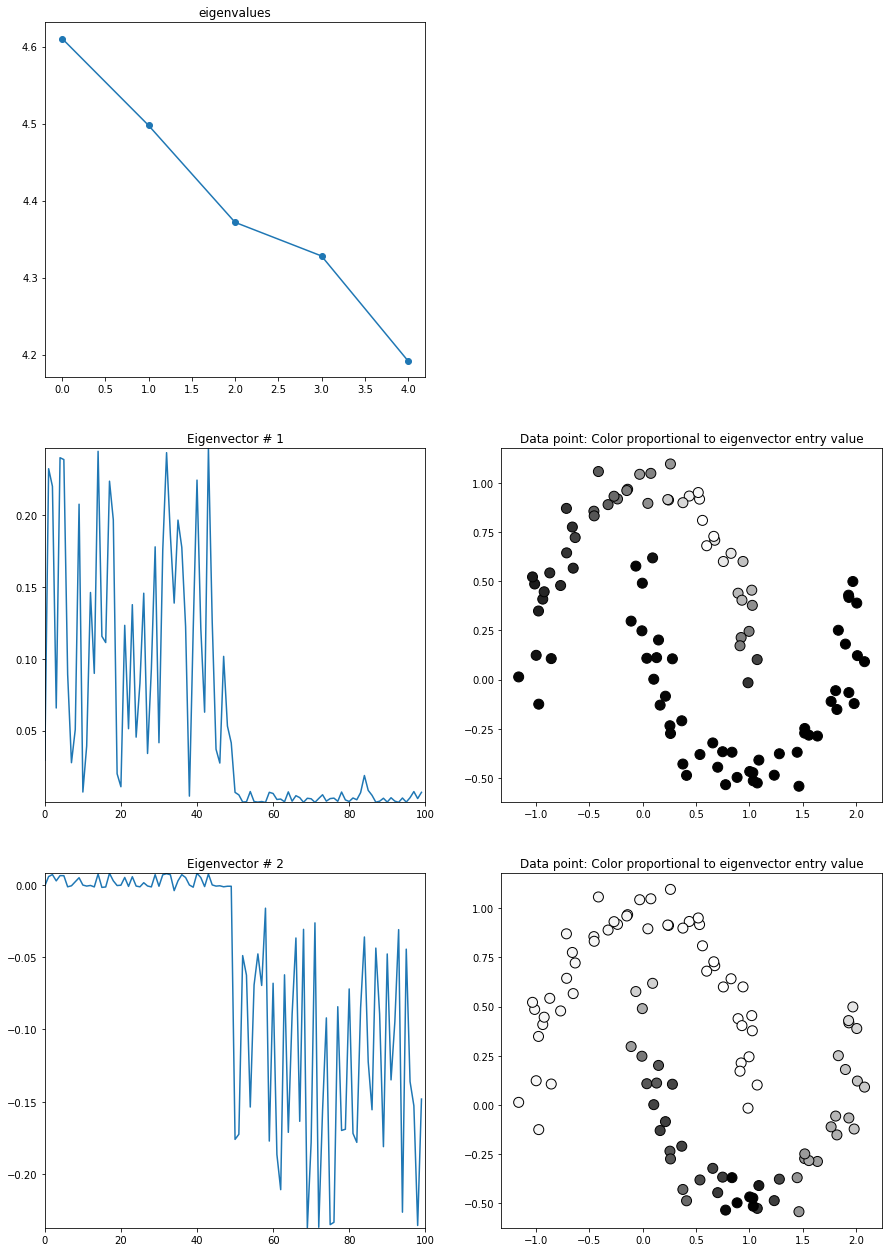

In [7]:
# Computing Eigenvalues and Eigenvectors of the weight matrix and visualize them.

k_largest = 5
# Compute k-largest eigenvectors.
[eigenvalues, U]= torch.lobpcg(W, k=k_largest, method='ortho', largest=True)
eigenvalues = eigenvalues.cpu()
U = U.cpu()
# Note: computing eigenvalues and eigenvectors using eig function (as shown below) is wasteful
# as we do not need all the eigenvectors.
#[eigenvalues, U]=torch.eig(W, eigenvectors=True) #- wastefull as we do not need all the eigenvectors.

N = W.shape[0]
plt.figure(figsize=(15, 30))
plt.subplot(4,2,1)
plt.plot(eigenvalues, '-o')
plt.title('eigenvalues')

for i in range(0, 2) :
    plt.subplot(4,2,2*i+3)
    plt.plot(U[:,i])
    plt.axis([0, N, torch.min(U[:,i]), torch.max(U[:,i])])
    plt.title('Eigenvector # {}'.format(i+1))
  
    plt.subplot(4,2,2*i+4)
    plt.scatter(data[:,0], data[:,1], c= (U[:,i]-torch.min(U[:,i])), s=100, edgecolors="black")
    plt.gray()
    plt.title('Data point: Color proportional to eigenvector entry value')


# Inclass work (10 min)

1. Test that the eigenvectors of the weight matrix are orthonormal, i.e. orthonogal to each other, each vector has unit norm.

2. Show that ${\bf v}$ is an eigenvector, then so is $-{\bf v}$, i.e., there is sign ambiguity in the specification of the eigenvectors.

# Using eigenvectors to embed data in a new space

So far, we have seen how the **entries** of each eigenvector can be associated with the graph's respective vertices (nodes) to denote its participation in the possible cluster. Instead of considering these eigenvectors individually, we can think them as a group and associate a **"coordinate"** to each vertex (or node), which then can be used to **group** the vertices into clusters.

For each eigenvector, $\mathbf{v_i}$, the j-th entry, $v_{ij}$, is associated with the j-th data point or j-th graph node. If we take all the j-th entries of the eigenvectors, $\{v_{1,j}, v_{2, j}, \cdots, v_{N, j} \}$, it forms a cooridinate vector associated with the j-th node. We truncate and consider only the top k largest eigenvectors, then the new coordinate for each data point is only k-dimensional, $\{v_{1,j}, \cdots, v_{k, j} \}$.

We usually multiply these entries with the sqrt of the eigenvalues to make them proportional to the dimension's overall strength. (The choice of the sqrt is not arbitrary but has a mathematical reason. But that discussion is a long sidebar.) Remember, the eigenvalues capture the average coherence with the nodes' weights according to the corresponding eigenvector. Thus, the new coordinates are:

\begin{equation}
\mathbf{x_i}^{new} = \left [ \sqrt{\lambda_1} v_{1,i}, \cdots, \sqrt{\lambda_k} v_{k,i} \right ]^T
\end{equation}
 


# Other possible matrix representations

In addition to the weighted adjacency matrix representation, other possible matrix representations of graphs include the Laplacian, signed Laplacian, and normalized versions of these representations. Here we define some of these. The suitability of each representation is dependent on the application.

A graph **Laplacian** is defined as $L = D - W$, where $D$ is a diagonal matrix composed of each vertex *degree*. The degree of a vertex $v_i$ is the total of the weights of the edges connected to the vertex.

\begin{equation}
d_i = \sum_{j=1}^N w_{ij} 
\end{equation}

The degree of a vertex is a measure of how well the node is connected to other nodes. The degree matrix $D$ is defined as the diagonal matrix with the degrees, $\{d_i, \cdots, d_N\}$, on the diagonal. Note that the Laplacian matrix is also symmetric, and the off-diagonal terms are negative. **The sum of the rows and the columns of the Laplacian is zero.** The graph Laplacian was used by ([Sarkar and Soundararajan, 2000](https://ieeexplore.ieee.org/abstract/document/857006)) to group edge segments in images.

The signless **Laplacian** is defined as $Q = D + W$. This matrix is also symmetric, however, the rows and the columns do not sum to zero. This has been proposed by ([Cvetković and Simić, 2010](https://www.sciencedirect.com/science/article/pii/S0024379509002808)) but never used in computer vision application as of today (Jan 2021).

There are also **normalized** versions of these representations. We will start with the normalized version of the original weighted adjacency matrix. The weight of each edge, $w_{ij}$, between two vertices $v_i$ and $v_j$ is normalized by the vertices' degrees. This was used by ([Shi and Malik, 2000](https://ieeexplore.ieee.org/document/868688)) for image segmentation. This is the famous normalized cut approach that appeared in the same year as the plain Laplacian proposal of Sarkar and Soundararajan.

\begin{equation}
w^{sym}_{ij} = \frac{w_{ij}}{\sqrt{d_i} \sqrt{d_j}}
\end{equation}

There is a second way to normalize the weight matrix, but that does not result in a symmetric matrix. 

\begin{equation}
w^{rw}_{ij} = \frac{w_{ij}}{d_i}
\end{equation}
This matrix is related to random walks on the graph hence the superscript rw. Note $w^{rw}_{ij} \neq w^{rw}_{ji}$.

The two kinds of normalized adjacency matrices can be expressed in matrix form as 
\begin{equation}
W_{sym} = D^{-\frac{1}{2}} W D^{-\frac{1}{2}}
\end{equation}
and
\begin{equation}
W_{rw} = D^{-1} W 
\end{equation}

Using these normalized versionf of the weight adjacency matrices, we can define normalized version of the Laplacian and the sunsigned Laplacian matrices as follows
\begin{eqnarray}
L_{sym} & = & I - W_{sym} = I - D^{-\frac{1}{2}} W D^{-\frac{1}{2}} = D^{-\frac{1}{2}} (D - W) D^{-\frac{1}{2}} = D^{-\frac{1}{2}} L D^{-\frac{1}{2}} \\
L_{rm} & = & I - W_{rm} = I - D^{-1} W  = D^{-1} (D - W) = D^{-1} L  \\
Q_{sym} & = & I + W_{sym} = I + D^{-\frac{1}{2}} W D^{-\frac{1}{2}} = D^{-\frac{1}{2}} (D + W) D^{-\frac{1}{2}} = D^{-\frac{1}{2}} Q D^{-\frac{1}{2}} \\
Q_{rm} & = & I + W_{rm} = I + D^{-1} W  = D^{-1} (D + W) = D^{-1} L  \\
\end{eqnarray}

For more information about spectral clustering read the following papers

Von Luxburg, Ulrike. "[A tutorial on spectral clustering](https://link.springer.com/article/10.1007/s11222-007-9033-z)." Statistics and computing 17.4 (2007): 395-416.

Cvetković, Dragoš, and Slobodan Simić. "[Graph spectra in computer science](https://www.sciencedirect.com/science/article/pii/S0024379510006117)." Linear Algebra and its Applications 434.6 (2011): 1545-1562.


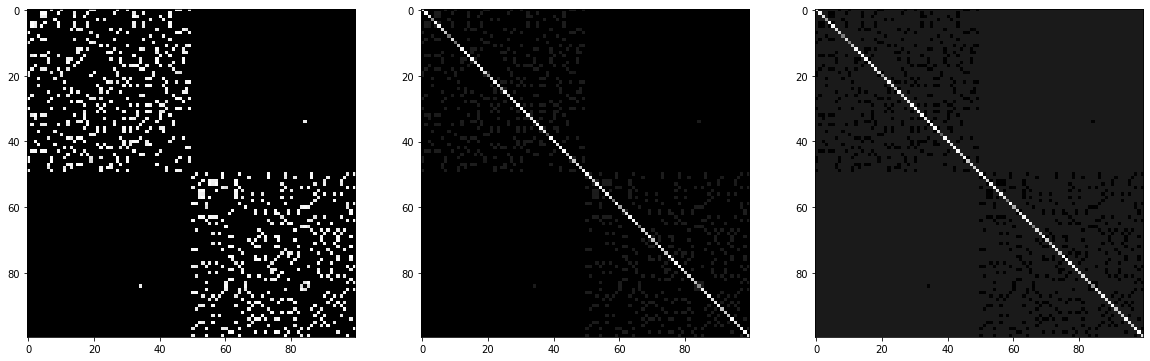

In [8]:
D = torch.diag_embed(W.sum(0))
D_inv = torch.diag_embed(1/W.sum(0))
D_invsqrt = torch.diag_embed(1/torch.sqrt(W.sum(0)))

W_sym = D_invsqrt @ (W @ D_invsqrt)
W_rw = D_inv @ W

L = D - W
Q = D + W
L_sym = torch.eye(W.shape[0]) - W_sym 
L_rw = torch.eye(W.shape[0]) - W_rw
Q_sym = torch.eye(W.shape[0]) + W_sym 
Q_rw = torch.eye(W.shape[0]) + W_rw


# Visualize the matrix
plt.figure(figsize=(20,20))
plt.subplot(2,3,1)
plt.imshow(W.cpu(), 'gray')
plt.subplot(2,3,2)
plt.imshow(Q.cpu(), 'gray')
plt.subplot(2,3,3)
plt.imshow(L.cpu(), 'gray')

# Spectral Clustering Algorithm

1. Input:  Data $X$ and $k$ - the number of clusters to construct.

2. Construct a similarity graph, represented by its weighted adjacency matrix, ${\bf W}$. 
3. (optional) Normalize the weight matrix ${\bf W}$ by the vertex degrees.
4. (optional) Compute other variations such as the Laplacian ${\bf L}$, or signless or normalized versions of it.
5.  Compute the first $k$ largest eigenvectors of the adjacency form 
>>>(or $k+1$ smallest eigenvectors of the Laplacian form). 
6. Let ${\bf X}^{new} = [ (\lambda_1)^{\frac{1}{2}}{\bf u_1}, \cdots, (\lambda_k)^{\frac{1}{2}}{\bf u_k} ]$ be the matrix containing the eigenvector as columns. Let the corresponding eigenvalues be $\lambda_1, \cdots, \lambda_k$. The number of rows of its matrix will be equal to the number of data points. 
>>>(If working with a Laplacian form, ignore the smallest eigenvector, which is associated with a eigenvalue of zero, and arrange the rest as a matrix, multiplied by the inverse of the corresponding eigenvalue. ${\bf X}^{new} = [ (\lambda_1)^{-\frac{1}{2}}{\bf u_1}, \cdots, (\lambda_k)^{-\frac{1}{2}}{\bf u_k} ]$)

7. Assign the $i$-th row of this matrix, weighted by the corresponding eigenvalue is the new coordinate of the $i$-th data point. 

>> $\begin{equation}
 {\bf x_i}^{new} = [(\lambda_1)^{\frac{1}{2}} u_{1i}, (\lambda_2)^{\frac{1}{2}}u_{2i}, \cdots, (\lambda_k)^{\frac{1}{2}} u_{ki}]^T
 \end{equation}$

>>>>>(If working with the Laplacian form use: $\begin{equation}
{\bf x_i}^{new} = [(\lambda_1)^{-\frac{1}{2}} u_{1i}, (\lambda_1)^{-\frac{1}{2}} u_{2i}, \cdots, (\lambda_1)^{-\frac{1}{2}} u_{ki}]^T
\end{equation}$)

8. Perform k-means or EM on this new transform data matrix, whose rows are the data units.

9. Output: the clusters returned by k-means or EM



torch.Size([100, 2]) torch.Size([2]) torch.Size([100, 2]) torch.float32


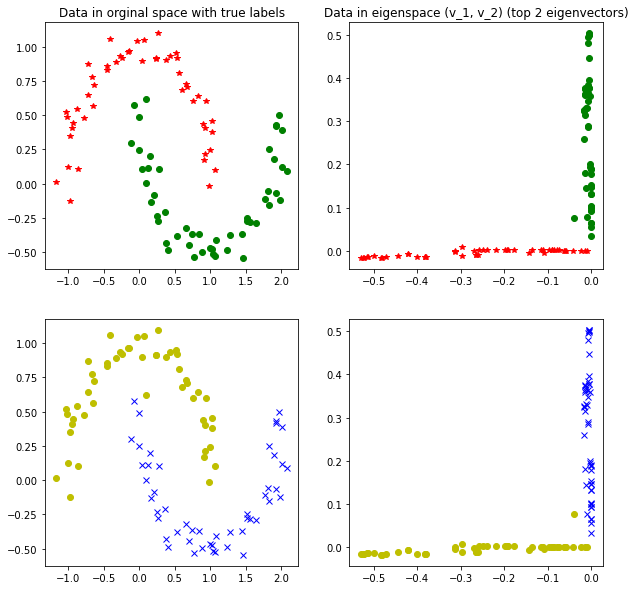

In [9]:
# Cluster in the new transformed dimension


k_selected = 2
# Compute k-selected eigenvectors.

#---------------Compute Weight Matrix   -----------------------
#-----     For W, Q, and their normalized version W_sym, W_rm, Q, Q_sym, Q_rw use the following
[eigenvalues, U]=torch.lobpcg(W, k=k_selected, method='ortho', largest=True)
#-----     Compute Graph Spectral Space-----------------------
data_new = U * torch.sqrt(eigenvalues)

#------------------------------------------------------------------
#-----     For Laplacian, L, and its normalized versions, L_sym, L_rw use the following three lines 
#[eigenvalues, U]=torch.lobpcg(L_sym, k=k_selected+1, method='ortho', largest=False)
#U = U[:, 1:k_selected+1]; # For Laplacian we have to ignore the smallest eigenvector, which will be all ones.
#eigenvalues = eigenvalues[1:k_selected+1]
#-----     Compute Graph Spectral Space
#data_new = U * torch.sqrt(1/eigenvalues)
#------------------------------------------------------------------

print(U.shape, eigenvalues.shape, data_new.shape, data_new.dtype)

#---------------------Using k-means------------------------------------- 
#labels, mu = nD_k_Means (data_new.double().cuda(), 2)

#---------------------Using EM ------------------------------------- 
Z, mu, Sigma = nD_EM_GMM (data_new.double().cuda(), 2)
val, labels = torch.max(Z, 1)


#---------------------Display-------------------------------------
plt.figure(figsize=(10, 10))
plt.subplot(2,2,1)
for i in range (data.shape[0]) :
    plt.plot(data[i,0], data[i,1], colors[data_labels[i]])
plt.title ('Data in orginal space with true labels')

data_new = data_new.cpu()
plt.subplot(2,2,2)
for i in range (data.shape[0]) :
    plt.plot(data_new[i,0], data_new[i,1], colors[data_labels[i]])
plt.title ('Data in eigenspace (v_1, v_2) (top 2 eigenvectors)');

plt.subplot(2,2,3)
for i in range (data.shape[0]) :
  plt.plot(data[i,0], data[i,1], colors[labels[i]+2])

plt.subplot(2,2,4)
for i in range (data.shape[0]) :
  plt.plot(data_new[i,0], data_new[i,1], colors[labels[i]+2])


# An example application in image segmentation

The most important part is the construction of the weight matrix. The more rich a feature set that goes into it, the better the performance.

In [10]:
from google.colab import drive
drive.mount('/content/drive')
!ls /content/drive/MyDrive/Colab\ Notebooks/data/


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
hawaii.png   house_2.png       lizard.jpg	  mountain_peak_1.png
house_1.png  house_facade.png  MOT16-08-raw.webm  mountain_peak_2.png


In [11]:
def reduce_size (img, scale_percent = 20) :
  #calculate the scale_percent of original dimensions
  width = int(img.shape[1] * scale_percent / 100)
  height = int(img.shape[0] * scale_percent / 100)
  # resize image
  return (cv2.resize(img, (width, height)))

In [12]:
#----------------------Functions used--------------------
#`squared_distance_batch` contains some broadcast magic that allows us to compute the distance from each point in a batch to all points in the data.
# See - https://numpy.org/doc/stable/user/basics.broadcasting.html
#  and https://scipy-lectures.org/intro/numpy/operations.html
def squared_distance_batch(b, a):
    #print(a.shape, a[None,:].shape, b.shape, b[:,None,:].shape)
    return (((a[None,:,:] - b[:,None,:]) ** 2).sum(2))

def gaussian(squared_dist, squared_bandwidth):
    return torch.exp(-0.5 * (squared_dist / (squared_bandwidth))) / (torch.sqrt(2 * squared_bandwidth*torch.tensor(np.pi)))


In [13]:
def compute_weight_matrix (data, batch_size) :
    X = torch.from_numpy(data).cuda()
    N = X.shape[0]
    print('Computing distances between pixels:')
    W = torch.zeros((X.shape[0], X.shape[0]))
    for i in range(0, N, batch_size):
        s = slice(i, min(N, i + batch_size))
        distance = squared_distance_batch(X, X[s])
        W[:,s] = distance
    
    #-----------------------------------------------------------
    print('Computing gaussian kernel', W.shape)
    kernel_width = torch.var(W)
    print('Gaussian kernel (variance of distances):', kernel_width)
    W = gaussian(W, kernel_width)

    return(W)


In [14]:
def spectral_clustering_torch (data, batch_size=500, type=0, k_selected = 2):
    
    W = compute_weight_matrix (data, batch_size)
    plt.subplot(5,2,2)
    plt.imshow(W)
    if type == 0 :
        #---------------Compute Weight Matrix   -----------------------
        #-----     For W, Q, and their normalized version W_sym, W_rm, Q, Q_sym, Q_rw use the following
        [eigenvalues, U]=torch.lobpcg(W, k=k_selected, method='ortho', largest=True)
        #-----     Compute Graph Spectral Space-----------------------
        data_new = U * torch.sqrt(eigenvalues)
    else :
        #------------------------------------------------------------------
        #-----     For Laplacian, L, and its normalized versions, L_sym, L_rw use the following three lines 
        [eigenvalues, U]=torch.lobpcg(L_sym, k=k_selected+1, method='ortho', largest=False)
        U = U[:, 1:k_selected+1]; # For Laplacian we have to ignore the smallest eigenvector, which will be all ones.
        eigenvalues = eigenvalues[1:k_selected+1]
        #-----     Compute Graph Spectral Space
        data_new = U * torch.sqrt(1/eigenvalues)
        #------------------------------------------------------------------

    print(U.shape, eigenvalues.shape, data_new.shape, data_new.dtype)

    #---------------------Using k-means------------------------------------- 
    labels, mu = nD_k_Means (data_new.double().cuda(), k_selected)

    #---------------------Using EM ------------------------------------- 
    # %time Z, mu, Sigma = nD_EM_GMM (data_new.double().cuda(), k_selected)
    #val, labels = torch.max(Z, 1)

    return (labels)

Input image size: (483, 323, 3)
Reduced image size: (169, 113, 3)
Computing distances between pixels:
Computing gaussian kernel torch.Size([19097, 19097])
Gaussian kernel (variance of distances): tensor(1.3088e+08)
torch.Size([19097, 3]) torch.Size([3]) torch.Size([19097, 3]) torch.float32
CPU times: user 4.71 s, sys: 2.24 s, total: 6.95 s
Wall time: 7.26 s


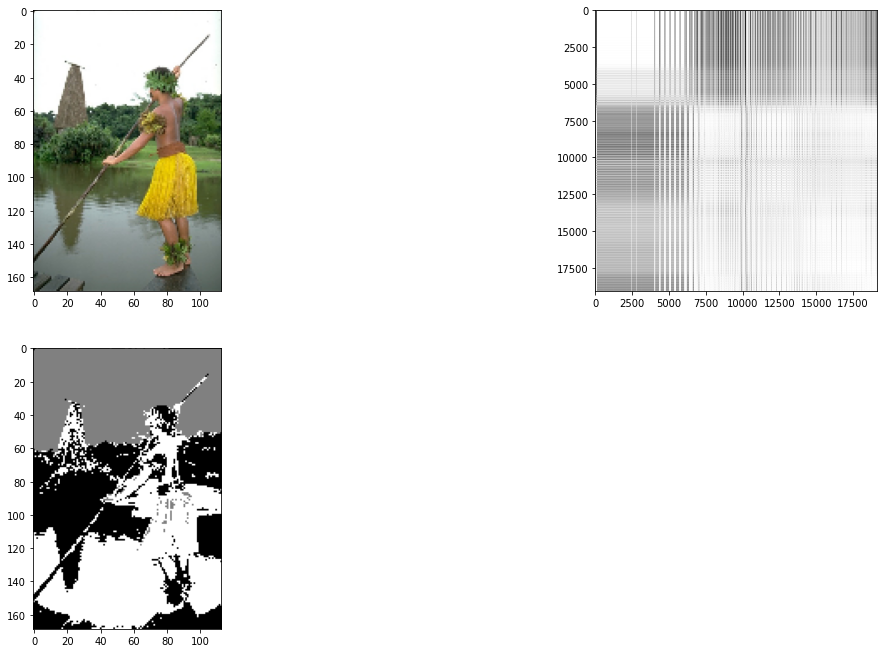

In [17]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import torch
plt.figure(figsize=(20,30))

# Load an color image in grayscale
img = cv2.imread('/content/drive/MyDrive/Colab Notebooks/data/hawaii.png')

# Change color spaces. Can experiment with other spaces.
img = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
print("Input image size:", img.shape)

img = reduce_size(img, scale_percent=35)
plt.subplot(5,2,1)
plt.imshow(cv2.cvtColor(img, cv2.COLOR_LAB2RGB))
print("Reduced image size:", img.shape)

pixels = np.float32(img.reshape((-1,3))) # change the shape of the 2D image into a 1D array

##------------------
%time X = spectral_clustering_torch(pixels, batch_size=50000, type=0, k_selected = 3).cpu().numpy()
##------------------

seg_img = np.uint8(X.reshape([img.shape[0], img.shape[1]]))
plt.subplot(5,2,3)
plt.imshow(seg_img)

# How do you evaluate which segmentation is better?

https://www2.eecs.berkeley.edu/Research/Projects/CS/vision/grouping/resources.html

**Berkeley Segmentation Data Set and Benchmarks 500 (BSDS500)**

This new dataset is an extension of the BSDS300, where the original 300 images are used for training / validation and 200 fresh images, together with human annotations, are added for testing. Each image was segmented by five different subjects on average. Performance is evaluated by measuring Precision / Recall on detected boundaries and three additional region-based metrics.
			